In [1]:
import os
import base64
import openai
import json
import time
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import openai
from transformers import pipeline
# from openai import OpenAI, AzureOpenAI
from dotenv import load_dotenv
import qa_package.dataclasses.orm as d
from sqlalchemy.engine import Engine, create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy.sql import select
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from qa_package.services.openai import OpenAI
from sklearn.cluster import KMeans

load_dotenv()

API_BASE = os.getenv('API_BASE')
API_KEY = os.getenv('API_KEY')
API_VERSION = os.getenv('API_VERSION')
CHAT_DEPLOYMENT_NAME = os.getenv('CHAT_DEPLOYMENT_NAME')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')
NEW_API_KEY = os.getenv('MY_API_KEY')
n_clusters = 10

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


In [2]:
# openai.api_key = NEW_API_KEY
# openai.api_type = "open_ai"
openai.api_key = API_KEY
openai.api_type = "azure"
openai.api_base = API_BASE
openai.api_version = API_VERSION

In [3]:
CSV_FILE = "/Users/spare/Documents/data/articles.csv"
df = pd.read_csv(CSV_FILE)

- https://help.openai.com/en/articles/7102672-how-can-i-access-gpt-4 (I cannot use this)
- https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding (cannot use)
- https://huggingface.co/tasks/image-to-text
- 

#### downloading could not show progress bar
- Run this in terminal `watch du -h  ~/.cache/huggingface/hub `

In [4]:
captioner = pipeline("image-to-text",
        model="Salesforce/blip-image-captioning-base")

<img src="https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png">

- url input for caption

In [5]:
captioner(
    "https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png"
)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'two birds are standing next to each other birds'}]

In [6]:
root_img_path = "/Users/spare/Documents/data/images/"
img_paths = os.listdir(root_img_path)

0554598009.jpg


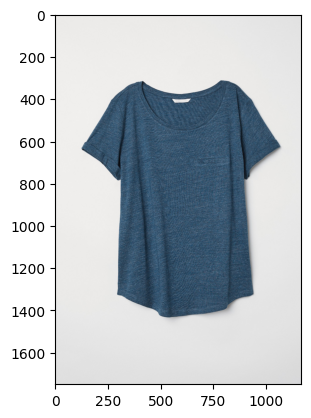

In [7]:
tmpimg = mpimg.imread(root_img_path+img_paths[0])
plt.imshow(tmpimg)
print(img_paths[0])

- local image path for caption

In [8]:
captioner(root_img_path+img_paths[0])

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]

In [9]:
df[df.article_id==int(img_paths[0].replace(".jpg",""))]

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,garment_group_name,detail_desc
157,554598009,Nora T-shirt,T-shirt,Garment Upper body,Melange,Dark Blue,Jersey Basic,"T-shirt in soft jersey with a round neck, shor..."


- base 64 encoded string for caption

In [10]:
base64_image = encode_image(root_img_path+img_paths[0])

In [11]:
captioner(base64_image)

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'the organic linen top in indigo blue'}]

## Test embeddings with other fields

In [12]:
df

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,garment_group_name,detail_desc
0,695255001,Siv t-shirt,T-shirt,Garment Upper body,All over pattern,Dark Blue,Jersey Fancy,Short-sleeved top in soft viscose jersey with ...
1,821115007,RICHIE SKIRT,Skirt,Garment Lower body,Check,Pink,Skirts,"Short, pleated skirt in woven fabric with a hi..."
2,553238008,THORN LS TEE,Sweater,Garment Upper body,Solid,White,Jersey Basic,"Wide, long-sleeved top in soft cotton jersey w..."
3,627147001,Bling Me Up Push,Bikini top,Swimwear,Lace,Dark Red,Swimwear,"Fully lined bikini top with hole-patterned, un..."
4,794520001,Plus seam at back 1p tights,Underwear Tights,Socks & Tights,Solid,Black,Socks and Tights,Tights with a seam down the back of the legs. ...
...,...,...,...,...,...,...,...,...
995,734225001,Madonna set,Dungarees,Garment Full body,Application/3D,Light Grey,Woven/Jersey/Knitted mix Baby,Set with a pair of dungaree shorts in woven fa...
996,549332001,Mataro ED jacket,Jacket,Garment Upper body,All over pattern,Greenish Khaki,Outdoor,"Jacket in soft, patterned cotton twill with a ..."
997,720217002,Venus Braces Skirt,Skirt,Garment Lower body,Chambray,Light Blue,Dresses/Skirts girls,Gently flared dungaree dress in airy cotton ch...
998,751254003,Runaway lace dress,Dress,Garment Full body,Lace,Red,Jersey Fancy,"Short, sleeveless lace dress in a narrow cut a..."


In [13]:
client = OpenAI(
    api_key=API_KEY, api_base=API_BASE, api_version=API_VERSION
)

In [14]:
BATCH_SIZE = 16
BATCH = df.shape[0] // BATCH_SIZE + int(df.shape[0] % BATCH_SIZE > 0)
color_embeddings = []
for i in tqdm(range(BATCH)):
#     ids = df["article_id"][i * BATCH_SIZE : (i + 1) * BATCH_SIZE].tolist()
#     docs = [
#         pre_encoding_format.format(**tmp)
#         for tmp in df.iloc[i * BATCH_SIZE : (i + 1) * BATCH_SIZE].to_dict(
#             orient="records"
#         )
#     ]
    docs = df["colour_group_name"]\
        [i * BATCH_SIZE : (i + 1) * BATCH_SIZE].tolist()
#     print(docs)
    vecs = client.create_embeddings(docs, EMBEDDING_DEPLOYMENT_NAME)
    color_embeddings += vecs
    if i%30 == 0:
        time.sleep(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.67it/s]


In [15]:
pca_scores = PCA().fit_transform(color_embeddings)
df_pc = pd.DataFrame(pca_scores)

In [16]:
tsne_em = TSNE(n_components=2, 
    perplexity=30, early_exaggeration=12,
    n_iter=1000,learning_rate=368, 
    verbose=1).fit_transform(df_pc.loc[:,0:49])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.360962
[t-SNE] KL divergence after 1000 iterations: -4.611134


In [17]:
df_pc['tsne-pca50-one'] = tsne_em[:,0]
df_pc['tsne-pca50-two'] = tsne_em[:,1]

In [18]:
cmatrix = np.vstack(color_embeddings)

In [19]:
kmeans = KMeans(n_clusters = n_clusters, 
        init='k-means++', random_state=42)
kmeans.fit(cmatrix)
df_pc['y'] = kmeans.labels_

/Users/spare/Documents/miniconda3/envs/new-qa/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

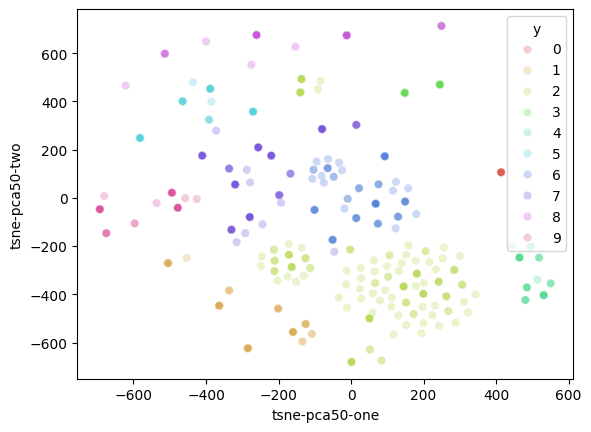

In [20]:
sns.scatterplot(
    x='tsne-pca50-one', y='tsne-pca50-two',
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_pc,
    legend="full",
    alpha=0.3,
#     ax=ax1
)